# Deep Learning for timeseries

## Different kinds of timeseries tasks

A timeseries can be any data obtained via mesurements at regular intervals, like the daily price of a stock, hourly electricity consumption of a city, or the weekly sales of a store. Timeseries are every where, whether we're looking at natural phenomena or human activity patterns. Unlike the types of data encountered so fa, working with timeseries involves understanding the dynamics of a system-its periodic cycles, how it trends over time, its regular regime and its sudden spikes.
By far, the most common timeseries-related task is forecasting: predicting what will happen next in a series. Forecast electricity consumption a few hours in advance so you can anticipate demand. forecasting is what this chapter focuses on. But there are actually a wide range of other things you can do with timeseries:

* Classification - Assign one or more categorical labels to a timeseries. For instance, given the timeseries of the activity of a visitor on a website, classify wheter the visitor is a bot or a human.
* Event detection - Identify the occurence of a specific expected event within a continuous data stream. A particularly useful application is "hotword detection", where a model monitors and audio stream and detects utteracnes like "Ok Google" etc..
* Anomaly detection - Detect anything unusual happening within a continuous datastream. Unusual activity on your corporate network? Might be an attacker. Unusual readings on a manufacturing line? Time for a human to take a look. Anomaly detection is typically done via unsupervised learning, because you often do not know what kind of anomaly you are looking for, so you cannot train on specific anomaly examples.

When working with timeseries, you will encounter a wide range of domain-specific data representations techniques. For instance, you have likely already heard about the Fourier transform, which consists of expressing a series of a values in terms of a superposition of waves of different frequencies. the Fourier transform can be highly valuable when preprocessing anydata that is primarily characterized by its cycles and oscillations. In the context of deep learning, Fourier analysis and other domain-specific representations can be useful as a form of feature engineering, a way to prepare data before trainin a model on it, to make the job of the model easier.

## A temperature-forecasting example

Throughout this chapter all the code will target a single problem: predicting the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the recent past by a set of sensors on the roof a of a building. 
We'll see that densely connected networks and convolutional networks are not well-equipped to deal with this kind of dataset, while a different kind of machine learning tachnique- recurrent neural networks (RNN) - really shines on this type of problem.

In [3]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

In [3]:
import os
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
#Parsing the data
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines),len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    temperature[i] = values[1]
    raw_data[i,:] = values[:]

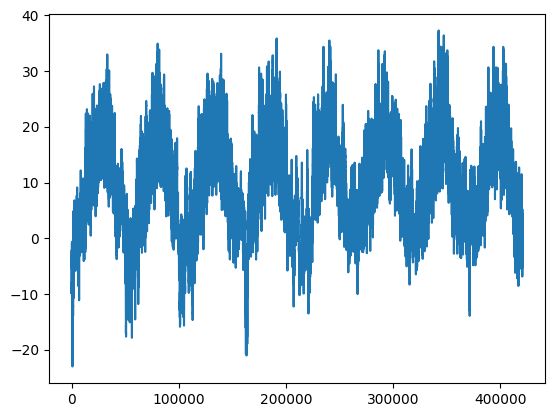

In [5]:
import matplotlib.pyplot as plt
plt.plot(range(len(temperature)),temperature)

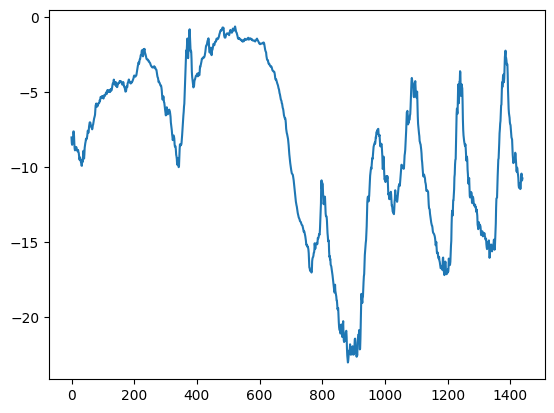

In [6]:
plt.plot(range(1440),temperature[:1440])

##### Always look for periodicity in your data
Periodicity over multiple timescales is an important and very common property of timeseries data. Whether you are looking at weather, parking occupancy, etc.., you will see daily cycles and yearly cycles. When exploring your data, make sure to look for these patterns.

When working with timeseries data, it is important to use validation and test data that is more recent that the training data, because you are trying to predict the future given the past, and your validation/test split should reflect that.

In [7]:
num_train_samples=int(0.5*len(raw_data))
num_val_samples = int(0.25*len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("Num Train Samples: ", num_train_samples)
print("Num Val Samples: ", num_val_samples)
print("Num Test Samples: ", num_test_samples)


Num Train Samples:  210225
Num Val Samples:  105112
Num Test Samples:  105114


### Preparing the data
Exact formulation of the problem will be: Given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?\
First, let's preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need vectorization. But each timeseries in the data is on a different scale. We normalize each timeseries independently so that they all take small values on a similar scale.

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std =raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Now let's create a Dataset object that yields batches of data from the past five days along wiht a target temperature 24 hours in the future. Because the samples in the dataset are highly redundant, it would be wasteful to explicitly allocate memory for every sample.
Instead, we'll generate the samples on the fly while only keeping in memory the original raw_data and temperature arrays, and nothing more.


##### Understanding timeseries_dataset_from_array()
To understand what timeseries_dataset_from_array() does, let's look at a simple example. The general idea is that you provide an array of timeseries data, and timeseries_dataset_from_array() gives you windows extracted from the original timeseries.
For example, if you use data=[0 1 2 3 4 5 6] and sequence_lenght=3, then timeseries_dataset_from_array() will generate the following samples: [0 1 2], [1 2 3], [2 3 4], [3 4 5], [4 5 6].\
You can also pass a targets argument to timeseries_dataset_from_array(). The first entry of the targets array should match the desired target for the first sequence that will be generated from the data array. So if you are doing timeseries forecasting, targets should be the same array as data, offset by some amount.
For instance, with data=[0 1 2 3 4 5 6] and sequence_length=3, you could create a dataset to predict the next step in the series by passing targets=[3 4 5 6 ].\
Let's try:

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


We'll use timeseries_dataset_from_array() to instantiate three datasets: one for trainin, one for validation, and one for testing.
We'll use the following parameter values:
* sampling_rate = 6 - Obseration will be sampled at one data point per hour: we will only keep one data point out of 6.
* sequence_length = 120 - Observations will go back 5 days
* delay = sampling_rate * (sequence_length+24-1) - Target for a sequence will be the temperature 24 hours after the end of the sequence.


In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length+24-1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples+num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples+num_val_samples,
)

Each dataset yields a tuple (sample,targets), where samples is a batch of 256 samples, each contains 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures.

In [11]:
for samples, targets in train_dataset:
    print('sample shape:', samples.shape)
    print('targets shape:', targets.shape)
    break


sample shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine learning baseline

Let's try a simple, common-sense approach. Serves as a sanity check, and will establish a baseline that we'll have to beat in order to demonstrate the usefulness of more-advanced machine learning models.
Such baselines can be useful when you are approaching a new problem for which there is no known solution.

In [12]:
#MAE common-sense baseline

def evaluate_naive_method(dataset):
    total_abs_err=0.
    samples_seen=0
    for samples, targets in dataset:
        preds = samples[:, -1,1]*std[1]+mean[1]
        total_abs_err += np.sum(np.abs(preds-targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f'Validation MAE: {evaluate_naive_method(val_dataset):.2f}')
print(f'Test MAE: {evaluate_naive_method(test_dataset):.2f}')

Validation MAE: 2.44
Test MAE: 2.62


### Let's try basic machine learning

In the same way it's useful to try simple, cheap machine learning models before looking into complicated and expensive RNNs. this is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.
The following listing shows a fully connected model starting wiht flattening the data and then runs it through two Dense layers. The lack of an activation function which is typical for a regression problem. We use MSE as the loss because it's smooth around zero, which is a useful property for gradient descent.

In [22]:
from tensorflow import keras
from tensorflow.keras import layers

inputs=keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x=layers.Flatten()(inputs)
x= layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint('jena_dense.keras', save_best_only=True)]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model('jena_dense.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 [==============================] - 13s 15ms/step - loss: 11.7791 - mae: 2.6719 - val_loss: 10.7887 - val_mae: 2.5868
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 8.8878 - mae: 2.3464 - val_loss: 10.0412 - val_mae: 2.4770
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 8.1833 - mae: 2.2521 - val_loss: 13.8134 - val_mae: 2.9417
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 7.7018 - mae: 2.1835 - val_loss: 11.0349 - val_mae: 2.6168
Epoch 5/10
819/819 [==============================] - 13s 15ms/step - loss: 7.3725 - mae: 2.1363 - val_loss: 10.5717 - val_mae: 2.5623
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 7.1349 - mae: 2.1007 - val_loss: 10.7231 - val_mae: 2.5710
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 6.9289 - mae: 2.0738 - val_loss: 11.3042 - val_mae: 2.6364
Epoch 8/10
819/819 [==============================] - 

In [17]:
import matplotlib.pyplot as plt
def plot_hist(history):
    loss = history.history['mae']
    val_loss = history.history['val_mae']
    epochs = range(1,len(loss)+1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training MAE')
    plt.plot(epochs, val_loss,'b', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.show()


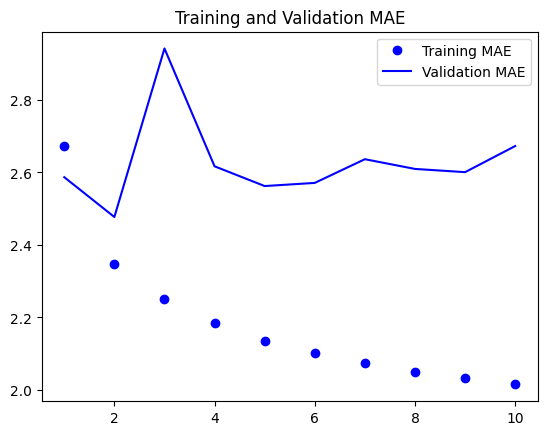

In [24]:
plot_hist(history)

Some of the validation losses are close to the no-learning vaseline, but not reliably.
This goes to show the merit of having this baseline in the first place: it turns out to be not wasy to outperform. Your common sense contains a lot of valuable information to which a machine learning model does not have access.
If a simple, well-performing model exists to go from the data to the targets, why doesn't the model you are training find it and improve on it? Well, the space ofa models in chiech you are searching for a solution, the hypothesis space, is the space of all possible two-layer networks with the configuration you diefined. The common-sense heuristic is just one model among milions that can be repesented in this spae.
Just because a good solution technically exists in you hypothesis space does not mean you will be able to find it via gradient descent.
That's a pretty significant limitiation of  machine learning in general: unless the learning algorithm is hardcoded to look for specific kind of simple model, it can sometimes fail to find a simple solution to a simple problem. That's why leveraging good feature engineering and relevant architecture priors is essential: you need to precisely tell your model what it should be looking for.

### Let's try a 1D convolutional model

speaking of leveraging the right architecture priors, since our input sequences feature daily cycles, perhaps a convolutional model could work. A temporal convnet could reuse the same prepresentations across different days, much like a spatial convnet can reuse the same represetnations across different locations in an image.\
We have already seen 2D conv layers which see their inputs through small windows that swipe across 2D grids. There are also 1D and even 3D versions of these layers. The conv1D layer relies on 1D windows that slide across input sequences, and the conv3d layer relies on cubic windows that slide across input volumes.\
You can thus build 1D convnets, strictly analogous to 2D convnets. They are a great fit for any sequence data that follows the translation invariace assumption.

In [25]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.Conv1D(8,24,activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8,12,activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8,6,activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint('jena_conv.keras',save_best_only=True)]
model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model('jena_conv.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')


Epoch 1/10
819/819 [==============================] - 17s 20ms/step - loss: 26.9965 - mae: 3.8996 - val_loss: 21.2106 - val_mae: 3.6854
Epoch 2/10
819/819 [==============================] - 16s 19ms/step - loss: 15.3222 - mae: 3.1030 - val_loss: 15.8481 - val_mae: 3.1247
Epoch 3/10
819/819 [==============================] - 15s 19ms/step - loss: 14.3462 - mae: 3.0081 - val_loss: 14.5409 - val_mae: 3.0142
Epoch 4/10
819/819 [==============================] - 16s 19ms/step - loss: 13.5890 - mae: 2.9295 - val_loss: 17.3936 - val_mae: 3.3260
Epoch 5/10
819/819 [==============================] - 16s 19ms/step - loss: 12.8920 - mae: 2.8506 - val_loss: 14.8208 - val_mae: 3.0466
Epoch 6/10
819/819 [==============================] - 17s 20ms/step - loss: 12.2585 - mae: 2.7800 - val_loss: 14.3001 - val_mae: 2.9774
Epoch 7/10
819/819 [==============================] - 17s 21ms/step - loss: 11.7020 - mae: 2.7126 - val_loss: 15.0508 - val_mae: 3.0630
Epoch 8/10
819/819 [============================

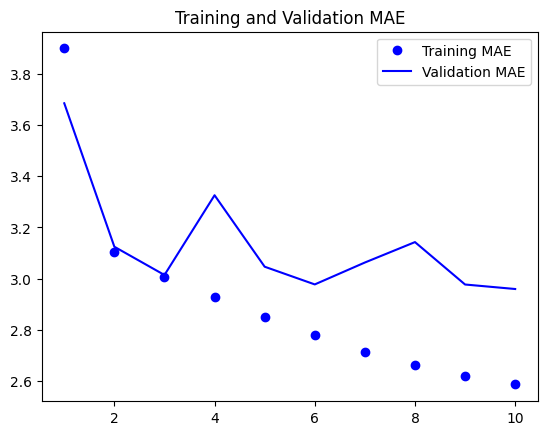

In [26]:
plot_hist(history)

As it turns out, this model performs even worse than the densely connected one, only achieving a validation MAE of 2.9 degrees, far from the common-sense baseline.\
What went wrong? Two things:
1. Weather data does not quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or middle of the night. Weather data is only translation-invariant for a very specific timescale.
2. Order in our data matters a lot. The recent past is far more informative for predicting the next day's temperature than data from five days ago. A 1D convnet is not able to leverage this fact. Our max pooling and global average pooling layers are largely destroying order information.

### A first recurrent baseline
Neither the fully connected approach nor convolutional approach did well, but that does not mean machine learning is not applicable to this problem. The densely connected approach first flattened the timeseries, which removed the notion of time from the input. The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information. Let's look instead at the data as what it is: a sequence, where causality and order matter.
There is a family of neural networks architectures designed specifically for this use case: recurrent neural networks.\
Among them, Long Short Term Memory(LSTM) layer has long been very popular.

In [31]:
#Simple LSTM-based model

inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)

callbacks = [keras.callbacks.ModelCheckpoint('jena_lstm.keras', save_best_only=True)]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_dataset,epochs=10,validation_data=val_dataset,callbacks=callbacks)
model = keras.models.load_model('jena_lstm.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 [==============================] - 21s 24ms/step - loss: 48.6593 - mae: 5.1207 - val_loss: 14.1924 - val_mae: 2.8357
Epoch 2/10
819/819 [==============================] - 18s 22ms/step - loss: 11.1551 - mae: 2.5916 - val_loss: 9.9624 - val_mae: 2.4587
Epoch 3/10
819/819 [==============================] - 18s 22ms/step - loss: 9.6974 - mae: 2.4315 - val_loss: 10.0811 - val_mae: 2.4714
Epoch 4/10
819/819 [==============================] - 18s 22ms/step - loss: 9.3551 - mae: 2.3853 - val_loss: 10.1195 - val_mae: 2.4733
Epoch 5/10
819/819 [==============================] - 18s 22ms/step - loss: 9.0792 - mae: 2.3488 - val_loss: 10.4057 - val_mae: 2.4980
Epoch 6/10
819/819 [==============================] - 18s 21ms/step - loss: 8.8100 - mae: 2.3157 - val_loss: 10.3758 - val_mae: 2.5072
Epoch 7/10
819/819 [==============================] - 18s 22ms/step - loss: 8.5768 - mae: 2.2867 - val_loss: 10.3855 - val_mae: 2.5049
Epoch 8/10
819/819 [==============================] - 

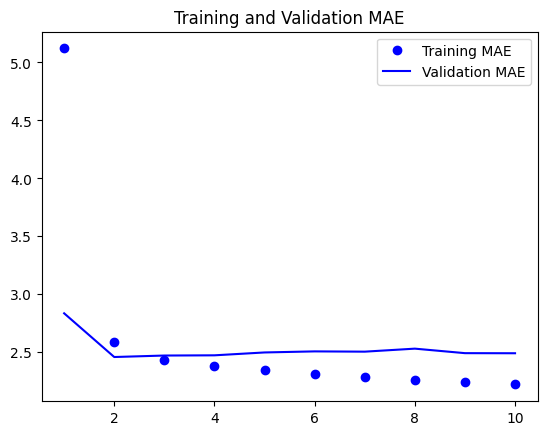

In [32]:
plot_hist(history)

Much Better! We achieved a validation MAE as low as 2.36 deggrees and test MAE of 2.55 degrees. The LSTM based model can finally beat the common-sense baseline, demonstrating the value of machine learning on this task.\
But why did LSTM model perform better than the others? And how can we further refine our model? Let's take a closer look at RNNs.

## Understanding RNNs
A recurrent neural network(RNN) adopts the same principle, albeit in an extremely simplidied version: it processes sequences by iterating though the sequence elements and maintaining a state that contains information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop. The state of the RNN is reset between processing two different, independent sequences, so you still consider one sequence to be a single data point: a single input to the network. What changes is that this data point is no longer processed in a single step, rather, the network internally loops over sequence elements.\
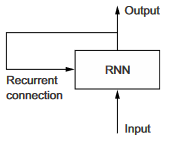\
To make these notions of loop and state clear, let's implement the forward pass of a toy RNN. This RNN takes as input a sequence of vectors, which we'll encode as a rank-2 tensor of size (timesteps, input_features). It loops over timesteps, and at each timestep, it considers its current state at t and the input at t (of shape (input_features,)), and combines them to obtain the output at t. We'll then set the state for the next step to be this previous output. For the first timestep, the previous output is not defined; hence, there is no current state. so we'll initialize the state as an all-zero vector called the initial state of the network.

In [ ]:
#pseudo-code RNN
state_t=0
for input_t in input_sequence:
    output_t = activation(dot(W,input_t)+dot(U, state_t)+b)
    state_t  = output_t

Let's write a numpy implementation of the forward pass of the simple RNN.

In [33]:
#NumPy implementation of a simple RNN

import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps,input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features,input_features))
U = np.random.random((output_features,output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W,input_t)+np.dot(U,state_t)+b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In summary, RNN is a for loop that reuses quantities computed during the previous iteration of the loop. There are many different RNNs fitting this definition that you could build. RNNs are characterized by their step function, such as the following function in this case.\
\
output_t = np.tanh(np.dot(W,input_t)+np.dot(U,state_t)+b)\
\
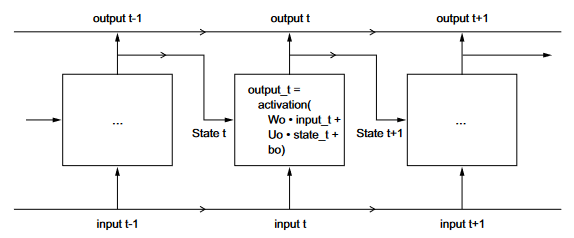

### A recurrent layer in Keras
The process we just implemented in NumPy corresponds to an actual Keras layer - SimpleRNN.\
There is a minor difference: SimpleRNN processes batches of sequences not a single sequence. This means it takes inputs of shape (batch_size,timesteps, input_features), rather than (timesteps,input_features). When specifying the shape argument of the initial Input(), note that you can set the timesteps entry to None, which enables your network to process sequences of arbitrary length.

In [34]:
num_features = 14
inputs = keras.Input(shape=(None,input_features))
outputs = layers.SimpleRNN(16)(inputs)

This is useful if your model is meant to process sequences of variable length. If all of your sequences have the same length, it is reccomended to specify a complete input shape,since it enables model.summary() to display output length information, which is always nice. All recurrent layers in Keras can be run in two different modes: they can return either full sequences of successive outputs for each tmestep or return only the last output for each input sequence. These two modes are controlled by the return_sequences constructor arguments.

In [35]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps,num_features))
outputs = layers.SimpleRNN(16,return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [36]:
#RNN returning its full output sequence
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps,num_features))
outputs = layers.SimpleRNN(16,return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [37]:
#Stacking RNN layers
inputs = keras.Input(shape=(steps,num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

SimpleRnn has a major issue: although it should theoretically be able to retain at time t information about inputs seen many timesteps before, such long-term dependencies prove impossible to learn in practice. This is due tothe vanishing gradient problem, an effect that is similar to what is observed with non-recurrent networks that are many layers deep.\
Thankfully SimpleRNN is not the only RNN in Keras. There are two others LSTM and GRU.\
LSTM is a variant of SimpleRNN layer, it adds a way to carry information across many timesteps. It saves information for later, thus preventing older signals from gradually vanishing during processing. This should remind you of residual connections. To understand this process in detail, we start from the SimpleRNN cell. Because you have a lot of weight matrices, index the W and U matrices in the cell, with the letter o (Wo and Uo) for output.\
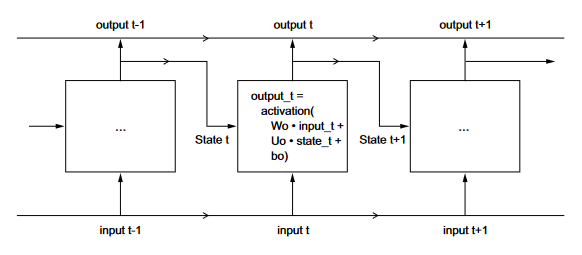\
Let's add to this picture an additional data flow that carries info across timesteps.\
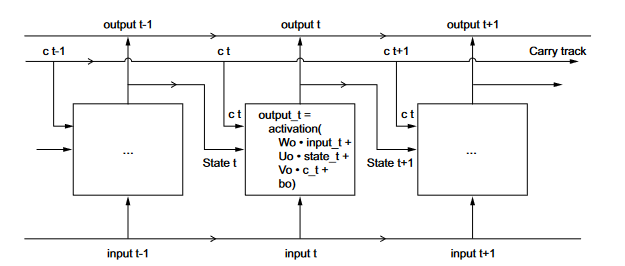\
This information will have the following impact on the cell: it will be combined with the input connection and the recurrent connection, and it will affect the state being sent to the next timestep. Conceptually, the carry dataflow is a way to modulate the next output and next state.\
Now, the way the next value of the carry dataflow is computed. It involves three distinct transformations. All three have the form of a SimpleRNN cell:\
y = activation(dot(state_t, U) + dot(input_t, W) + b)\
\
But all three have their own weight matrices.

In [ ]:
# #Pseudocode details of LSTM
# output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)
# i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
# f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
# k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)
# c_t+1 = i_t * k_t + c_t * f_t

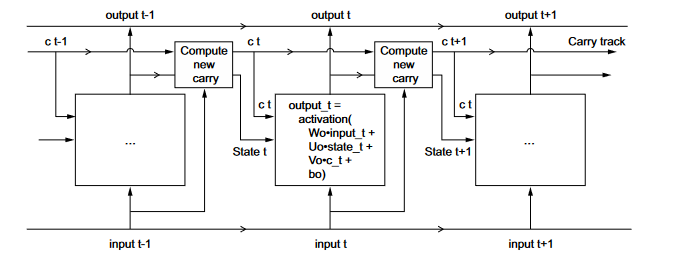\
What these operations actually do is determined by the contents of the weights parameterizing them: and the weights are learned in an end-to-end fashion, starting over with each training, round, making it impossible to credit this or that operation with a specific purpose. Specification of RNN cell determines the hypothesis space, the space in which you search for a good model configuration during training, but does not determine what the cell does, that is up to the weights.\
The same cell with different weights can be doing very different things. So the combination of operations making up an RNN cell is better interpreted as a set of constraints on your search, not as a design in an engineering sense.\
In summary: You do not need to understand anything about the specific architecture of an LSTM cell, as a human, it should not be your job to understand it. Just keep in mind what the LSTM cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.

## Advanced use of RNNs

So far we have learned:
* What RNN are and how they work
* What LSTM is, and why it works better on long sequences than native RNN
* How to use Keras RNN layers to process sequence data

Next we review a number of more advanced features of RNNs. By the end of the section, you will know most of what there is to know about using RNN in Keras.
We'll cover:
* Recurrent dropout - Variant of dropout, used to fight overfitting in Recurrent Layers
* Stacking recurrent layers - This increases the representational power of the model
* Bidirectional Recurrent layers - These present the same info to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

### Using Recurrent dropout to fight overfitting

If we loo at the training and validation curves of our LSTM model, it is evident that the model is quickly overfitting, despote having only few units: training and validation losses start to diverge considerably after a few epoch. The proper way to use a dropout with a recurrent network is to apply the same dropout mask at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep. In order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally costant dropout mask should be applied to inner recurrent activations of the layer. Using the same mask at every timestep allows the network to properly propagate its learning error through time, a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.\
Every Keras recurrent layer has two dropout-related arguments:
* dropout-a float specifying the dropout rate for input units of the layer
* recurrent_dropout - specifying the dropout rate of the recurrent units.
Thanks to dropout, we won't need to rely as much on network size for regularization, so we'll use an LSTM layer with twice as many units, which should be more expressive.

In [15]:
#Training and evaluating a dropout-regularized LSTM
from tensorflow import keras
from tensorflow.keras import layers


inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras', save_best_only=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,epochs=50, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 859s 1s/step - loss: 26.6602 - mae: 3.8203 - val_loss: 9.8805 - val_mae: 2.4342
Epoch 2/50
819/819 [==============================] - 829s 1s/step - loss: 14.5653 - mae: 2.9636 - val_loss: 9.5513 - val_mae: 2.4025
Epoch 3/50
819/819 [==============================] - 834s 1s/step - loss: 13.6894 - mae: 2.8679 - val_loss: 9.6754 - val_mae: 2.4035
Epoch 4/50
819/819 [==============================] - 860s 1s/step - loss: 13.0854 - mae: 2.8052 - val_loss: 9.5518 - val_mae: 2.3954
Epoch 5/50
819/819 [==============================] - 895s 1s/step - loss: 12.6291 - mae: 2.7558 - val_loss: 9.7182 - val_mae: 2.4224
Epoch 6/50
819/819 [==============================] - 891s 1s/step - loss: 12.2971 - mae: 2.7186 - val_loss: 9.8272 - val_mae: 2.4264
Epoch 7/50
819/819 [==============================] - 862s 1s/step - loss: 11.9581 - mae: 2.6795 - val_loss: 9.7763 - val_mae: 2.4291
Epoch 8/50
819/819 [==============================] - 826s 1s/

KeyboardInterrupt: 

In [18]:
plot_hist(history)

NameError: name 'history' is not defined

### Stacking recurrent layers

Because we are no longer overfitting but seem to have hit a performance bottleneck, you should consider increasing the capacity and expressive power of the network. Recall the description of the universal machine learning workflow: it's generally a good idea to increase the capacity of your model until overfitting becomes the primary obstace. As long as you are not overfitting too badly, you are likely under capacity.\
Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build more-powerful recurrent networks.\
To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs rather than their output at the last timestep. This is done by specifying return_sequences=True.\
In the following example, we'll try a stack of two  dropout-regularized recurrent layers. For a change, we'll use Gated Recurrent Unit (GRU) instead of LSTM. GRU is very similar to LSTM.

In [20]:
#Training and evaluating a dropout-regularized, stacked GRU model.

inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.GRU(32,recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32,recurrent_dropout=0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)

callbacks = [keras.callbacks.ModelCheckpoint('jena_stacked_gru_dropout.keras',save_best_only=True)]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_dataset,epochs=50,validation_data=val_dataset,callbacks=callbacks)

model = keras.models.load_model('jena_stacked_gru_dropout.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/50
  8/819 [..............................] - ETA: 29:29 - loss: 138.3747 - mae: 9.8394

KeyboardInterrupt: 

We achieve test MAE of 2.39 degres. You can see that the added layer does improve the results a bit, though not dramatically.

In [ ]:
plot_hist(history)

### Using bidirectional RNNs

The last technique we'll look is the bidirectional RNN. Which is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. It's frequently used in NLP.\
RNNs are order-dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence. This is precisely the reason they perform well on problems where order is meaningful, such as the temperature forecasting problem. A bidirectional RNN exploits the order sensitivity of RNNs: it uses two regualar RNNs, such as GRU and LSTM layers you are already familiar with, each of which processes the input sequence in one direction, and then merges their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.\
The fact that the RNN layers in this section have processed sequences in chronological order may have been an arbitrary decision. Could RNNs have performed well enough if they processed input sequences in antichronological order?\
Let's see, all we need to do is write a variant of the data generator where the input sequences are reverted along the time dimension.
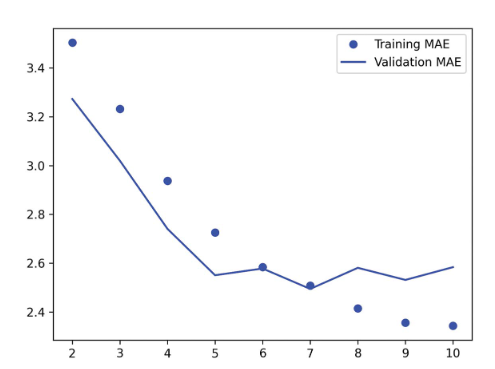\
The reversed-order LSTM strongly underperfoms even the common-sense baseline, indicating that in this case, chronological processing is important to the success of the approach. The undelying LSTM layer will typically to be better at remembering the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points for the problem. Thus the chronological version of the layer is bound to outperform the revered-order version.\
This isn't true for many other problems, including natural language: intuitively, the importance of a word in understanding a sentence isn't usually dependent on its position in the sentence. On text data, reversed-order processing works just aas well as chronological processing. Although word order does matter in understanding language, which order you use isn't crucial.\
An RNN trained on reversed sequences will learn different representations than one trained on the original sequences, much as you would have different mental models if time flowed backward in the real world. In ML, representations that are different yet useful are always worth exploiting, and the more they differ, the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other approaches, and thus they can help boost performance on a task.\
A bidirectional RNN exploits this idea to improve on the performance of chronological-order RNNs. It looks at its input sequence both ways, obtaining potentially richer represetnations and capturing patterns that may have been missed by chronological-order version alone.
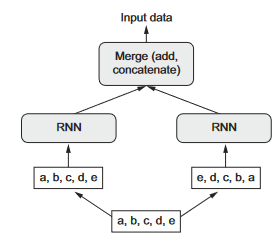\
To instantiate RNN in Keras, you use Bidirectional layer, which takes as its first argument a recurrent layer instance. Bidirectional creates a second, separate instance of this recurrent layer and uses one instance for processing the input sequences in chronological order and the other instance for processing the input sequences in reversed order.

In [21]:
#Training and evaluating a bidirectional LSTM

inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,epochs=10,validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 38s 31ms/step - loss: 26.0819 - mae: 3.6642 - val_loss: 10.8170 - val_mae: 2.5384
Epoch 2/10
819/819 [==============================] - 25s 30ms/step - loss: 9.5862 - mae: 2.4202 - val_loss: 10.0427 - val_mae: 2.4484
Epoch 3/10
819/819 [==============================] - 23s 28ms/step - loss: 8.7932 - mae: 2.3076 - val_loss: 9.8788 - val_mae: 2.4233
Epoch 4/10
819/819 [==============================] - 22s 27ms/step - loss: 8.2497 - mae: 2.2357 - val_loss: 10.1537 - val_mae: 2.4595
Epoch 5/10
819/819 [==============================] - 22s 27ms/step - loss: 7.8297 - mae: 2.1796 - val_loss: 10.7476 - val_mae: 2.5233
Epoch 6/10
819/819 [==============================] - 22s 27ms/step - loss: 7.5247 - mae: 2.1341 - val_loss: 10.5371 - val_mae: 2.5089
Epoch 7/10
819/819 [==============================] - 24s 29ms/step - loss: 7.2682 - mae: 2.0971 - val_loss: 11.0005 - val_mae: 2.5702
Epoch 8/10
819/819 [==============================] - 2

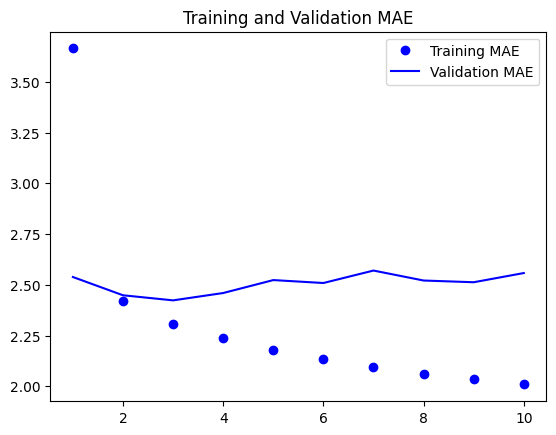

In [22]:
plot_hist(history)

You will find that it does not perform as well as plain LSTM. It is easy to understand why: all predictive capacity must come from the chronological half of the network, because the antichronological half is known to be severely underperforming on this task. At the same time, the presence of the antichronological half double the network's capacity and causes it to start overfitting much earlier.
Bidirectional RNNs are a great fit for text data, or any other kind of data where order matters, yet where which order you use doesn't matter.

### Going even further
There are many other things you could try to improve performance on the temperature-forecasting problem:
* Adjust the number of units in each recurrent layer in the stacked setup, as well as the amount of dropout. The current choices are largely arbitrary and thus probably suboptimal.
* Adjust the learning rate used by the RMSprop optimizer, or try a different one.
* Try stacking Dense layers as the regressor on top of the recurrent layer, instead of a single Dense layer.
* Improve the input to the model: try using longer or shorter sequences or a different sampling rate, or start doing feature engineering.

